In [1]:
#working with dataset
import pyarrow as pa
import pyarrow.parquet as pq
import re
import string
import pandas as pd
import numpy as np
import re #regular expression
import matplotlib.pyplot as plt
import seaborn as sns
#preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')
#training the model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pq.read_table('kinopoisk-train.parquet')
df = pa.Table.to_pandas(df)

In [3]:
df.grade3.replace("Good", 1, inplace=True) 
df.grade3.replace("Neutral", 2, inplace=True) 
df.grade3.replace("Bad", 3, inplace=True) 

Text(0.5, 1.0, 'Количество отзывов')

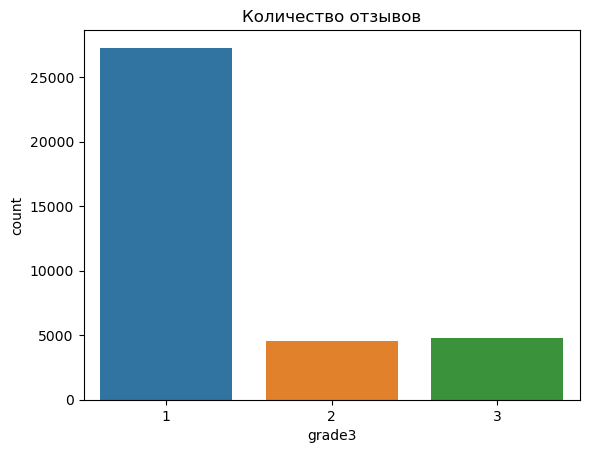

In [4]:
sns.countplot(x='grade3', data=df)
plt.title("Количество отзывов")

In [5]:
train_df, test_df = train_test_split(df, test_size=3500)

In [6]:
russian_stop_words = stopwords.words("russian")
snowball = SnowballStemmer(language="russian")
def tokenize_sentence(text):
    text = text.replace(r'\n', ' ')
    pattern = "[^A-Za-zА-Яа-яЁё0-9]"
    text = re.sub(pattern," ",text) 
    text = text.lower()
    tokens = word_tokenize(text, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [9]:
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer = tokenize_sentence, lowercase=False)),
    ("model", LogisticRegression(multi_class='multinomial', solver='lbfgs',random_state=0))])

In [10]:
mp = model_pipeline.fit(train_df["content"], train_df["grade3"])

C:\Users\USER\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
def Predictor(comment):
    return int(model_pipeline.predict([comment]))

In [12]:
from sklearn.metrics import precision_score
precision_score(y_true=test_df["grade3"], y_pred=mp.predict(test_df["content"]), average='weighted')

0.8136107450920328

In [13]:
print(Predictor('Отличный фильм!'))

1


In [14]:
print(Predictor('Нормально'))

2


In [15]:
print(Predictor('Ужасный фильм'))

3


In [17]:
import pickle
pickle.dump(mp, open('model.pkl','wb'))

model = pickle.load(open('model.pkl','rb'), encoding="UTF-8")
print(model.predict(['Отличный фильм!']))

[1]
